# Imports

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the Dataset

In [171]:
# Load the data
df = pd.read_csv('netflix_titles.csv')

In [172]:
# Display the first few rows of the dataset
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# Data Exploration

In [176]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

# Data Preprocessing

In [179]:
# Fill missing values for 'director', 'cast', and 'country' with 'Unknown'
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)

# Drop rows with missing 'date_added', 'rating', or 'duration'
df.dropna(subset=['date_added', 'rating', 'duration'], inplace=True)

# Extract numerical values from 'duration'
def extract_duration(duration):
    if 'Season' in duration:
        return int(duration.split(' ')[0]) * 60  # Assume 1 season = 60 minutes
    else:
        return int(duration.split(' ')[0])

df['duration'] = df['duration'].apply(extract_duration)

# One-hot encode 'type', 'country', and 'rating'
df = pd.get_dummies(df, columns=['type', 'country', 'rating'])

# Display the first few rows of the preprocessed dataset
df.head()

C:\Users\Micha\AppData\Local\Temp\ipykernel_13616\1822295446.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)
C:\Users\Micha\AppData\Local\Temp\ipykernel_13616\1822295446.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

,show_id,title,director,cast,date_added,release_year,duration,listed_in,description,type_Movie,...,rating_PG-13,rating_R,rating_TV-14,rating_TV-G,rating_TV-MA,rating_TV-PG,rating_TV-Y,rating_TV-Y7,rating_TV-Y7-FV,rating_UR
0,s1,Dick Johnson Is Dead,Kirsten Johnson,Unknown,"September 25, 2021",2020,90,Documentaries,"As her father nears the end of his life, filmm...",True,...,True,False,False,False,False,False,False,False,False,False
1,s2,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...","September 24, 2021",2021,120,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",False,...,False,False,False,False,True,False,False,False,False,False
2,s3,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...","September 24, 2021",2021,60,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,False,...,False,False,False,False,True,False,False,False,False,False
3,s4,Jailbirds New Orleans,Unknown,Unknown,"September 24, 2021",2021,60,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",False,...,False,False,False,False,True,False,False,False,False,False
4,s5,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...","September 24, 2021",2021,120,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,False,...,False,False,False,False,True,False,False,False,False,False


# Feature Selection

In [182]:
# Select relevant features and target
features = df.drop(columns=['show_id', 'title', 'director', 'cast', 'date_added', 'listed_in', 'description'])

# Ensure all feature columns are numerical
features = features.apply(pd.to_numeric, errors='coerce')

# Filter the target columns
target = df.filter(regex='rating_')

# Convert DataFrame to NumPy arrays and ensure the data is float type
X = features.to_numpy().astype(np.float32)
y = target.to_numpy().astype(np.float32)

# Data Splitting

In [185]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the datasets
print(X_train.shape, X_valid.shape, X_test.shape)

(6153, 767) (1318, 767) (1319, 767)


# Model

In [188]:
# Build the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

C:\Users\Micha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [190]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [192]:
# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,470 (419.80 KB)

 Trainable params: 107,470 (419.80 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [195]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [197]:
# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2494 - loss: 26.1909 - val_accuracy: 0.5152 - val_loss: 1.8538
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5105 - loss: 1.7340 - val_accuracy: 0.3225 - val_loss: 1.6404
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6299 - loss: 1.3485 - val_accuracy: 0.6821 - val_loss: 1.2970
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7327 - loss: 1.0915 - val_accuracy: 0.7056 - val_loss: 0.9650
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7909 - loss: 0.8065 - val_accuracy: 0.9173 - val_loss: 0.6473
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8967 - loss: 0.5360 - val_accuracy: 0.9036 - val_loss: 0.5969
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9323 - loss: 0.4378 - val_accuracy: 0.9294 - val_loss: 0.4387
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9429 - loss: 0.3587 - val_accuracy: 0

# Evaluation

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0119
Test Accuracy: 1.00


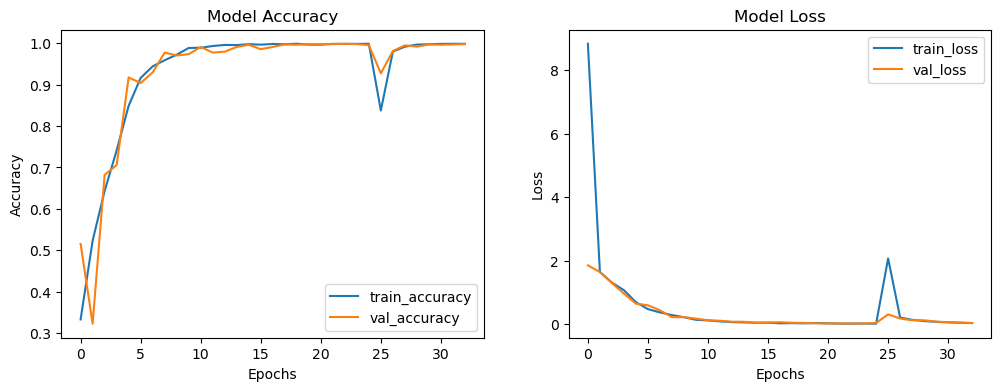

In [199]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

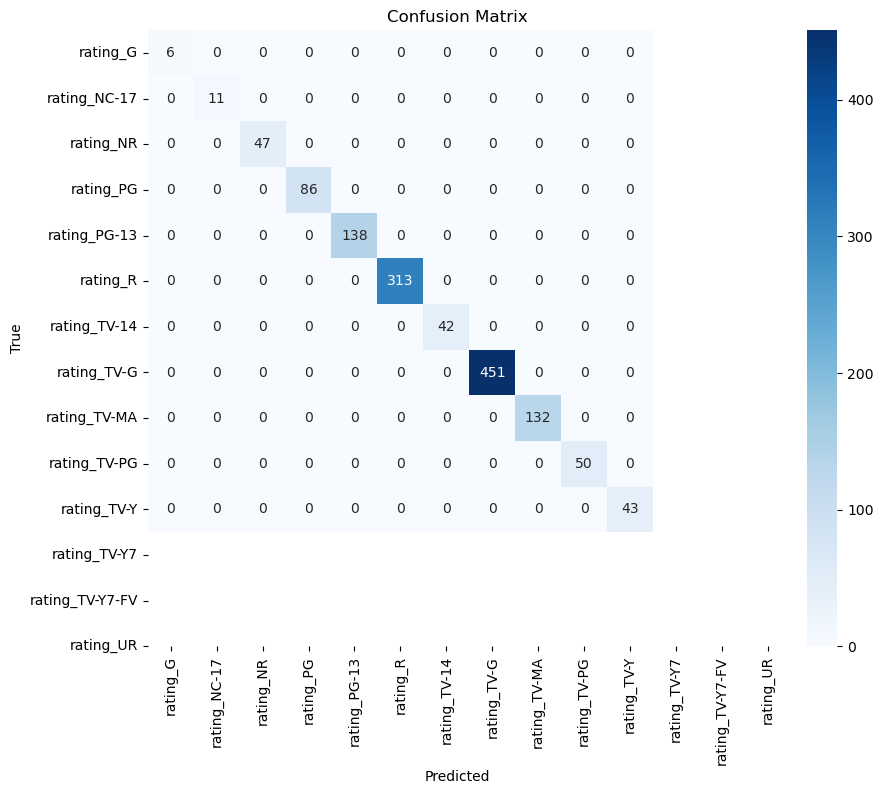

In [200]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target.columns, yticklabels=target.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [209]:
# Classification report
unique_classes = np.unique(y_true_classes)
target_names = [target.columns[i] for i in unique_classes]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

    rating_G       1.00      1.00      1.00         6
   rating_NR       1.00      1.00      1.00        11
   rating_PG       1.00      1.00      1.00        47
rating_PG-13       1.00      1.00      1.00        86
    rating_R       1.00      1.00      1.00       138
rating_TV-14       1.00      1.00      1.00       313
 rating_TV-G       1.00      1.00      1.00        42
rating_TV-MA       1.00      1.00      1.00       451
rating_TV-PG       1.00      1.00      1.00       132
 rating_TV-Y       1.00      1.00      1.00        50
rating_TV-Y7       1.00      1.00      1.00        43

    accuracy                           1.00      1319
   macro avg       1.00      1.00      1.00      1319
weighted avg       1.00      1.00      1.00      1319



In [218]:
# Rating Prediction: Predict the age rating of a title based on its metadata
def predict_rating(metadata, model, features, target, X_test, y_test):
    metadata = pd.DataFrame([metadata])
    metadata = pd.get_dummies(metadata)
    metadata = metadata.reindex(columns=features.columns, fill_value=0)
    metadata = metadata.to_numpy().astype(np.float32)
    
    prediction = model.predict(metadata)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_rating = target.columns[predicted_class[0]]
    
    # Evaluate model accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_percentage = accuracy * 100
    
    return predicted_rating, accuracy_percentage

In [222]:
example_metadata = {
    'release_year': 2021,
    'type': 'Movie',
    'country': 'United States',
    'duration': 90
}

predicted_rating, acc = predict_rating(example_metadata, model, features, target, X_test, y_test)
print(f'Predicted Rating: {predicted_rating}, Accuracy: {acc:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Rating: rating_TV-MA, Accuracy: 99.92%
